# Guide on how to use the backtester

In [1]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt
from backtester.log import Log
from backtester.log import Log





import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [2]:
def size_function(z, edge_0, edge_max, max_position = 50):
    z = np.array(z)
    direction = np.where(z > 0, -1, 1)
    abs_z = np.abs(z)
    size = np.where(
        abs_z <= edge_0,
        0,
        np.where(
            abs_z >= edge_max,
            max_position,
            max_position * ((abs_z - edge_0) / (edge_max - edge_0)) ** 2
        )
    )
    return direction * size

def exit_size_function(z, edge_0, edge_max, max_position = 50):
    # Positive quadratic function with points (0, 0) and (-2, 50)
    if z <= 0:
        if z >= -edge_0:
            return 0
        elif z <= -edge_max:
            return max_position
            
        a = -max_position/(edge_max - edge_0)**2
        return a * (z + edge_max)**2 + max_position
    else:
        if z <= edge_0:
            return 0
        elif z >= edge_max:
            return -max_position
        a = max_position/(edge_max - edge_0)**2
        return a * (z-edge_max)**2 - max_position


In [3]:
class Trader:

    kelp_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])

    resin_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])

    squink_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])
    # “If none of the bots trade on an outstanding player quote, the quote is automatically cancelled at the end of the iteration.”

    # I think this might make knowing which curve to move on easier, but what if the spread jumps from -50 to +50? 
    # We will def want to close out. I guess it depends on current position then
    z_ask = ""
    z_bid = ""
    
    def update_df(df, product, state, orders, order_depth):
        buy_orders = sorted(order_depth.buy_orders.items(), key=lambda x: -x[0])
        sell_orders = sorted(order_depth.sell_orders.items(), key=lambda x: x[0])

        bid_levels = buy_orders[:3] + [(None, None)] * (3 - len(buy_orders))
        ask_levels = sell_orders[:3] + [(None, None)] * (3 - len(sell_orders))

        if bid_levels[0][0] is not None and ask_levels[0][0] is not None:
            mid_price = (bid_levels[0][0] + ask_levels[0][0]) / 2
        else:
            mid_price = None

        row = {
            "timestamp": state.timestamp,
            "product": product,
            "bid_price_1": bid_levels[0][0], "bid_volume_1": bid_levels[0][1],
            "bid_price_2": bid_levels[1][0], "bid_volume_2": bid_levels[1][1],
            "bid_price_3": bid_levels[2][0], "bid_volume_3": bid_levels[2][1],
            "ask_price_1": ask_levels[0][0], "ask_volume_1": ask_levels[0][1],
            "ask_price_2": ask_levels[1][0], "ask_volume_2": ask_levels[1][1],
            "ask_price_3": ask_levels[2][0], "ask_volume_3": ask_levels[2][1],
            "mid_price": mid_price,
        }

        df.loc[len(df)] = row



    def run(self, state: TradingState):
        # Only method required. It takes all buy and sell orders for all symbols as an input, and outputs a list of orders to be sent
        # Trading Basket 1 against Basket 2: Djembes and B1 have position limits of 60. This should be the limiting
        # B1 = B2 + 2c + J - D
        result = {}
        synthetic_bid = 0    # What I can sell at
        synthetic_offer = 0    # What I can buy at

        best_bid_croissant, best_ask_croissant, best_ask_amount_croissant, best_bid_amount_croissant = 0, 0, 0, 0
        best_bid_djembes, best_ask_djembes, best_ask_amount_djembes, best_bid_amount_djembes = 0, 0, 0, 0
        best_bid_jams, best_ask_jams, best_ask_amount_jams, best_bid_amount_jams = 0, 0, 0, 0
        best_bid_b2, best_ask_b2, best_ask_amount_b2, best_bid_amount_b2 = 0, 0, 0, 0
        best_bid_b1, best_ask_b1, best_ask_amount_b1, best_bid_amount_b1 = 0, 0, 0, 0


        available_sell = 0
        available_buy = 0

        
        for product in state.order_depths:
            order_depth: OrderDepth = state.order_depths[product]
            orders: List[Order] = []
            # Basket 2 is 4 croissants, 2 jams
            if product == "CROISSANTS":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_croissant, best_ask_amount_croissant = list(order_depth.sell_orders.items())[0]
                    best_bid_croissant, best_bid_amount_croissant = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_croissant * 2
                    synthetic_offer += best_ask_croissant * 2
                    
            if product == "JAMS":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_jams, best_ask_amount_jams = list(order_depth.sell_orders.items())[0]
                    best_bid_jams, best_bid_amount_jams = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_jams * 1
                    synthetic_offer += best_ask_jams * 1
                    
            if product == "DJEMBES":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_djembes, best_ask_amount_djembes = list(order_depth.sell_orders.items())[0]
                    best_bid_djembes, best_bid_amount_djembes = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_ask_djembes * 1
                    synthetic_offer += best_bid_djembes * 1

            if product == "PICNIC_BASKET2":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_b2, best_ask_amount_b2 = list(order_depth.sell_orders.items())[0]
                    best_bid_b2, best_bid_amount_b2 = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_b2 * 1
                    synthetic_offer += best_ask_b2 * 1

            if product == "PICNIC_BASKET1": 
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_b1, best_ask_amount_b1 = list(order_depth.sell_orders.items())[0]
                    best_bid_b1, best_bid_amount_b1 = list(order_depth.buy_orders.items())[0]


        
        available_sell = min(int(best_bid_amount_croissant / 2), int(best_bid_amount_jams), int(abs(best_ask_amount_djembes)), best_bid_amount_b2)   # How many we can sell synthetica lly
        available_buy = min(int(abs(best_ask_amount_croissant) / 2), int(abs(best_ask_amount_jams)), int(abs(best_bid_amount_djembes)), int(abs(best_ask_amount_b2)))   # How many we can buy synthetically

        edge_0 = 120
        edge_max = 170

        edge_max_retreet = 30    #T HIS is higher than edge_0
        edge_0_retreet = -30

        position_max = int(60)

        basket_1_position = state.position.get("PICNIC_BASKET1", 0)

        # Redoing entry and exit scheme:
        z_mid = (best_bid_b1 + best_ask_b1)/2 - (synthetic_bid + synthetic_offer)/2
        
        pos_buy = size_function(z_mid, edge_0, edge_max, position_max)
        pos_sell = exit_size_function(z_mid, edge_0_retreet, edge_max_retreet, position_max)
        
        if z_mid > 0:
            # We only move on the entry curve. Enter more or hold.
            if pos_buy <= basket_1_position:
                target_position = pos_buy
                trade_needed = int(target_position - basket_1_position)
                trade_multiplier = min(abs(trade_needed), available_buy, abs(best_bid_amount_b1))
                
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_bid_b1, -trade_multiplier)]
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask_b2, trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_ask_jams, 1 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_ask_croissant, 2 * trade_multiplier)]
                result['DJEMBES'] = [Order('DJEMBES', best_ask_djembes, 1 * trade_multiplier)]


            else:
                target_position = max(pos_sell, min(basket_1_position, 0))
                
                trade_needed = int(target_position - basket_1_position)
                trade_multiplier = min(abs(trade_needed), available_sell, abs(best_ask_amount_b1))
                
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_ask_b1, trade_multiplier)]

                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid_b2, -1 * trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_bid_jams, -1 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_bid_croissant, -2 * trade_multiplier)]
                result['DJEMBES'] = [Order('DJEMBES', best_bid_djembes, -1 * trade_multiplier)]


        
        elif z_mid < 0:
            if pos_buy >= basket_1_position:
                target_position = pos_buy
                trade_needed = int(target_position - basket_1_position)
                trade_multiplier = min(abs(trade_needed), available_sell,abs(best_ask_amount_b1))
                
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_ask_b1, trade_multiplier)]

                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid_b2, -1 * trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_bid_jams, -1 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_bid_croissant, -2 * trade_multiplier)]
                result['DJEMBES'] = [Order('DJEMBES', best_bid_djembes, -1 * trade_multiplier)]


            else:
                target_position = min(pos_sell, max(basket_1_position, 0))
                trade_needed = int(target_position - basket_1_position)
                trade_multiplier = min(abs(trade_needed), available_buy,abs(best_bid_amount_b1))
                
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_bid_b1, -trade_multiplier)]
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask_b2, trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_ask_jams, 1 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_ask_croissant, 2 * trade_multiplier)]
                result['DJEMBES'] = [Order('DJEMBES', best_ask_djembes, 1 * trade_multiplier)]


 
        print(result)

        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData





In [38]:
# Basket 2 strat plus b1vb2

class Trader:

    kelp_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])

    resin_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])

    squink_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ])
    # “If none of the bots trade on an outstanding player quote, the quote is automatically cancelled at the end of the iteration.”

    # I think this might make knowing which curve to move on easier, but what if the spread jumps from -50 to +50? 
    # We will def want to close out. I guess it depends on current position then
    z_ask = ""
    z_bid = ""
    
    def update_df(df, product, state, orders, order_depth):
        buy_orders = sorted(order_depth.buy_orders.items(), key=lambda x: -x[0])
        sell_orders = sorted(order_depth.sell_orders.items(), key=lambda x: x[0])

        bid_levels = buy_orders[:3] + [(None, None)] * (3 - len(buy_orders))
        ask_levels = sell_orders[:3] + [(None, None)] * (3 - len(sell_orders))

        if bid_levels[0][0] is not None and ask_levels[0][0] is not None:
            mid_price = (bid_levels[0][0] + ask_levels[0][0]) / 2
        else:
            mid_price = None

        row = {
            "timestamp": state.timestamp,
            "product": product,
            "bid_price_1": bid_levels[0][0], "bid_volume_1": bid_levels[0][1],
            "bid_price_2": bid_levels[1][0], "bid_volume_2": bid_levels[1][1],
            "bid_price_3": bid_levels[2][0], "bid_volume_3": bid_levels[2][1],
            "ask_price_1": ask_levels[0][0], "ask_volume_1": ask_levels[0][1],
            "ask_price_2": ask_levels[1][0], "ask_volume_2": ask_levels[1][1],
            "ask_price_3": ask_levels[2][0], "ask_volume_3": ask_levels[2][1],
            "mid_price": mid_price,
        }

        df.loc[len(df)] = row



    def run(self, state: TradingState):
        # Only method required. It takes all buy and sell orders for all symbols as an input, and outputs a list of orders to be sent
        # Trading Basket 1 against Basket 2: Djembes and B1 have position limits of 60. This should be the limiting
        # B1 = B2 + 2c + J - D
        result = {}
        synthetic_bid = 0    # What I can sell at
        synthetic_offer = 0    # What I can buy at
        
        best_bid_croissant, best_ask_croissant, best_ask_amount_croissant, best_bid_amount_croissant = 0, 0, 0, 0
        best_bid_djembes, best_ask_djembes, best_ask_amount_djembes, best_bid_amount_djembes = 0, 0, 0, 0
        best_bid_jams, best_ask_jams, best_ask_amount_jams, best_bid_amount_jams = 0, 0, 0, 0
        best_bid_b2, best_ask_b2, best_ask_amount_b2, best_bid_amount_b2 = 0, 0, 0, 0
        best_bid_b1, best_ask_b1, best_ask_amount_b1, best_bid_amount_b1 = 0, 0, 0, 0


        available_sell = 0
        available_buy = 0

        for product in state.order_depths:
            order_depth: OrderDepth = state.order_depths[product]
            orders: List[Order] = []
            # Basket 2 is 4 croissants, 2 jams
            if product == "CROISSANTS":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_croissant, best_ask_amount_croissant = list(order_depth.sell_orders.items())[0]
                    best_bid_croissant, best_bid_amount_croissant = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_croissant * 2
                    synthetic_offer += best_ask_croissant * 2
                    
            if product == "JAMS":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_jams, best_ask_amount_jams = list(order_depth.sell_orders.items())[0]
                    best_bid_jams, best_bid_amount_jams = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_jams * 1
                    synthetic_offer += best_ask_jams * 1
                    
            if product == "DJEMBES":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_djembes, best_ask_amount_djembes = list(order_depth.sell_orders.items())[0]
                    best_bid_djembes, best_bid_amount_djembes = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_ask_djembes * 1
                    synthetic_offer += best_bid_djembes * 1

            if product == "PICNIC_BASKET2":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_b2, best_ask_amount_b2 = list(order_depth.sell_orders.items())[0]
                    best_bid_b2, best_bid_amount_b2 = list(order_depth.buy_orders.items())[0]
                    synthetic_bid += best_bid_b2 * 1
                    synthetic_offer += best_ask_b2 * 1

            if product == "PICNIC_BASKET1": 
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask_b1, best_ask_amount_b1 = list(order_depth.sell_orders.items())[0]
                    best_bid_b1, best_bid_amount_b1 = list(order_depth.buy_orders.items())[0]


        
        available_sell = min(int(best_bid_amount_croissant / 2), int(best_bid_amount_jams), int(abs(best_ask_amount_djembes)), best_bid_amount_b2)   # How many we can sell synthetica lly
        available_buy = min(int(abs(best_ask_amount_croissant) / 2), int(abs(best_ask_amount_jams)), int(abs(best_bid_amount_djembes)), int(abs(best_ask_amount_b2)))   # How many we can buy synthetically

        edge_0 = 50
        edge_max = 200

        edge_max_retreet = 120   #T HIS is higher than edge_0, 130 is good
        edge_0_retreet = -30

        position_max = int(60)

        basket_1_position = state.position.get("PICNIC_BASKET1", 0)

        # Redoing entry and exit scheme:
        z_mid = (best_bid_b1 + best_ask_b1)/2 - (synthetic_bid + synthetic_offer)/2
        
        pos_buy = size_function(z_mid, edge_0, edge_max, position_max)
        pos_sell = exit_size_function(z_mid, edge_0_retreet, edge_max_retreet, position_max)
        
        if z_mid > 0:
            # We only move on the entry curve. Enter more or hold.
            if pos_buy <= basket_1_position:
                target_position = pos_buy
                trade_needed = int(target_position - basket_1_position)
                trade_multiplier = min(abs(trade_needed), available_buy, abs(best_bid_amount_b1))
                
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_bid_b1, -trade_multiplier)]
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask_b2, trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_ask_jams, 1 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_ask_croissant, 2 * trade_multiplier)]
                result['DJEMBES'] = [Order('DJEMBES', best_ask_djembes, 1 * trade_multiplier)]


            else:
                target_position = max(pos_sell, min(basket_1_position, 0))
                
                trade_needed = int(target_position - basket_1_position)
                trade_multiplier = min(abs(trade_needed), available_sell, abs(best_ask_amount_b1))
                
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_ask_b1, trade_multiplier)]

                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid_b2, -1 * trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_bid_jams, -1 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_bid_croissant, -2 * trade_multiplier)]
                result['DJEMBES'] = [Order('DJEMBES', best_bid_djembes, -1 * trade_multiplier)]


        
        elif z_mid < 0:
            if pos_buy >= basket_1_position:
                target_position = pos_buy
                trade_needed = int(target_position - basket_1_position)
                trade_multiplier = min(abs(trade_needed), available_sell,abs(best_ask_amount_b1))
                
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_ask_b1, trade_multiplier)]

                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_bid_b2, -1 * trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_bid_jams, -1 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_bid_croissant, -2 * trade_multiplier)]
                result['DJEMBES'] = [Order('DJEMBES', best_bid_djembes, -1 * trade_multiplier)]


            else:
                target_position = min(pos_sell, max(basket_1_position, 0))
                trade_needed = int(target_position - basket_1_position)
                trade_multiplier = min(abs(trade_needed), available_buy,abs(best_bid_amount_b1))
                
                result['PICNIC_BASKET1'] = [Order('PICNIC_BASKET1', best_bid_b1, -trade_multiplier)]
                
                result['PICNIC_BASKET2'] = [Order('PICNIC_BASKET2', best_ask_b2, trade_multiplier)]
                result['JAMS'] = [Order('JAMS', best_ask_jams, 1 * trade_multiplier)]
                result['CROISSANTS'] = [Order('CROISSANTS', best_ask_croissant, 2 * trade_multiplier)]
                result['DJEMBES'] = [Order('DJEMBES', best_ask_djembes, 1 * trade_multiplier)]


 
        print(result)

        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData





Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [39]:
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_-1.csv"), sep=";")
market_data_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_0.csv"), sep=";")
market_data_day_neg2 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_1.csv"), sep=";")

trades_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_-1.csv"), sep=";")
trades_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_0.csv"), sep=";")
trades_day_neg2 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_1.csv"), sep=";")


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

market_data_all3days = concatenate_historical_data([market_data_day_neg2, market_data_day_neg1, market_data_day_0])
trades_all3days = concatenate_historical_data([trades_day_neg2, trades_day_neg1, trades_day_0])

In [40]:
market_data_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_-1.csv"), sep=";")
market_data_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_0.csv"), sep=";")
market_data_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_1.csv"), sep=";")

trades_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_-1.csv"), sep=";")
trades_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_0.csv"), sep=";")
trades_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_1.csv"), sep=";")


market_data_round_2_all3days = concatenate_historical_data([market_data_round_2_day_neg1, market_data_round_2_day_0, market_data_round_2_day_1])
trades_round_2_all3days = concatenate_historical_data([trades_round_2_day_neg1, trades_round_2_day_0, trades_round_2_day_1])

Lets run the backtester

In [41]:
market_data_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_0.csv"), sep=";")
market_data_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_1.csv"), sep=";")
market_data_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_2.csv"), sep=";")

trades_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_0.csv"), sep=";")
trades_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_1.csv"), sep=";")
trades_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_2.csv"), sep=";")



# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_3_all3days = concatenate_historical_data([market_data_round_3_day_0, market_data_round_3_day_1, market_data_round_3_day_2])
trades_round_3_all3days = concatenate_historical_data([trades_round_3_day_0, trades_round_3_day_1, market_data_round_3_day_2])

In [42]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
     "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
     "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
     "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    #"RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    #"VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    #"VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    #"VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    #"VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    #"VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    #"VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
     "CROISSANTS": 250,
     "DJEMBES": 60,
     "JAMS": 350,
    # "KELP": 50,
     "PICNIC_BASKET1": 60,
     "PICNIC_BASKET2": 100,
    #"RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
     #"VOLCANIC_ROCK": 400,
    #"VOLCANIC_ROCK_VOUCHER_10000": 200,
    #"VOLCANIC_ROCK_VOUCHER_10250": 200,
    #"VOLCANIC_ROCK_VOUCHER_10500": 200,
    #"VOLCANIC_ROCK_VOUCHER_9500": 200,
    #"VOLCANIC_ROCK_VOUCHER_9750": 200,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object
trader = Trader()

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_3_all3days, trades_round_3_all3days, output_log_filename = 'r3_b1vb2.log')


bt.run()


# double layer dictionary.
resinpnl = bt.pnl()["spreadcrossing"]["PICNIC_BASKET1"]
totalpnl = bt.pnl()["spreadcrossing"]["total"]
resinpnl, totalpnl, bt.pnl()

{'PICNIC_BASKET1': [(PICNIC_BASKET1, 59234, 0)], 'PICNIC_BASKET2': [(PICNIC_BASKET2, 30502, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)], 'DJEMBES': [(DJEMBES, 13493, 0)]}
{'PICNIC_BASKET1': [(PICNIC_BASKET1, 59233, 0)], 'PICNIC_BASKET2': [(PICNIC_BASKET2, 30501, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)], 'DJEMBES': [(DJEMBES, 13492, 0)]}
{'PICNIC_BASKET1': [(PICNIC_BASKET1, 59237, 0)], 'PICNIC_BASKET2': [(PICNIC_BASKET2, 30504, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)], 'DJEMBES': [(DJEMBES, 13493, 0)]}
{'PICNIC_BASKET1': [(PICNIC_BASKET1, 59233, 0)], 'PICNIC_BASKET2': [(PICNIC_BASKET2, 30499, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)], 'DJEMBES': [(DJEMBES, 13493, 0)]}
{'PICNIC_BASKET1': [(PICNIC_BASKET1, 59235, 0)], 'PICNIC_BASKET2': [(PICNIC_BASKET2, 30503, 0)], 'JAMS': [(JAMS, 6631, 0)], 'CROISSANTS': [(CROISSANTS, 4321, 0)], 'DJEMBES': [(DJEMBES, 13493, 0)]}
{'PICNIC_BASKET

(59750.0,
 51589.0,
 {'spreadcrossing': {'DJEMBES': -2556.0,
   'CROISSANTS': -3860.0,
   'JAMS': -4335.0,
   'PICNIC_BASKET1': 59750.0,
   'PICNIC_BASKET2': 2590.0,
   'total': 51589.0},
  'midpoint': {'DJEMBES': -1962.5,
   'CROISSANTS': -2720.0,
   'JAMS': -3530.5,
   'PICNIC_BASKET1': 64331.0,
   'PICNIC_BASKET2': 5170.0,
   'total': 61288.0}})

Available metrics: dict_keys(['timestamp', 'spreadcrossing_pnl', 'spreadcrossing_final_pnl', 'spreadcrossing_sharpe', 'spreadcrossing_pnl_bps', 'midpoint_pnl', 'midpoint_final_pnl', 'midpoint_sharpe', 'midpoint_pnl_bps'])


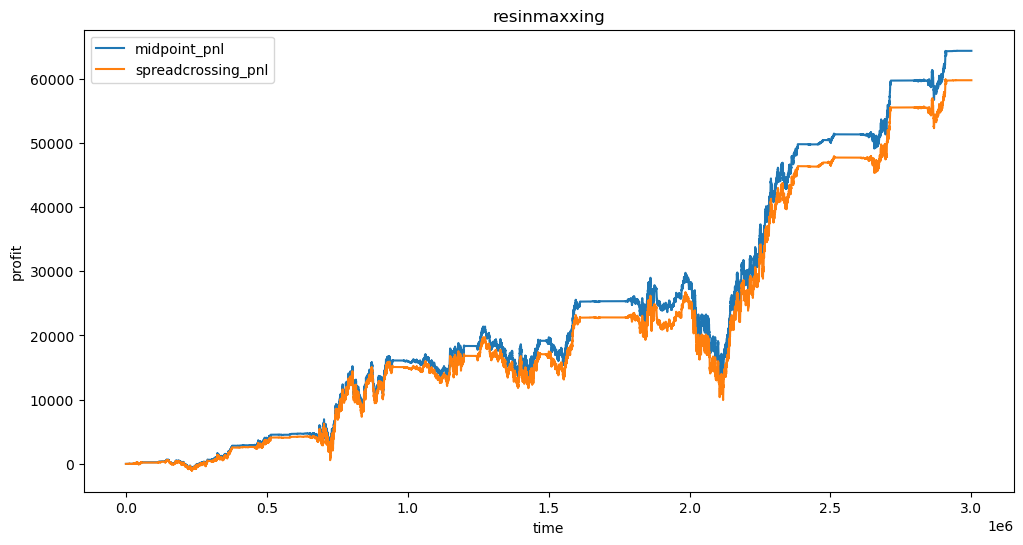

In [43]:
metrics = bt.calculate_metrics("PICNIC_BASKET1")

print(f"Available metrics: {metrics.keys()}")

# metrics['timestamp'] is provided for convenience.
# this should line up with metrics['midpoint_pnl'] and metrics['spreadcrossing_pnl'] (i.e. same shape)

plt.figure(figsize=(12, 6))
plt.plot(metrics["timestamp"], metrics["midpoint_pnl"], label="midpoint_pnl")
plt.plot(metrics["timestamp"], metrics["spreadcrossing_pnl"], label="spreadcrossing_pnl")
plt.title("resinmaxxing")
plt.xlabel("time")
plt.ylabel("profit")
plt.legend()

You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.

In [319]:
print(metrics['spreadcrossing_sharpe'])

-0.09624938864150567


In [320]:
print(metrics['midpoint_sharpe'])

-0.07958874824740182


In [321]:
resinpnl, totalpnl, bt.pnl()

(72745.0,
 58643.0,
 {'spreadcrossing': {'DJEMBES': -859.0,
   'CROISSANTS': -6108.0,
   'JAMS': -3904.0,
   'PICNIC_BASKET1': 72745.0,
   'PICNIC_BASKET2': -3231.0,
   'total': 58643.0},
  'midpoint': {'DJEMBES': -336.5,
   'CROISSANTS': -5099.0,
   'JAMS': -3228.0,
   'PICNIC_BASKET1': 76998.0,
   'PICNIC_BASKET2': -879.0,
   'total': 67455.5}})

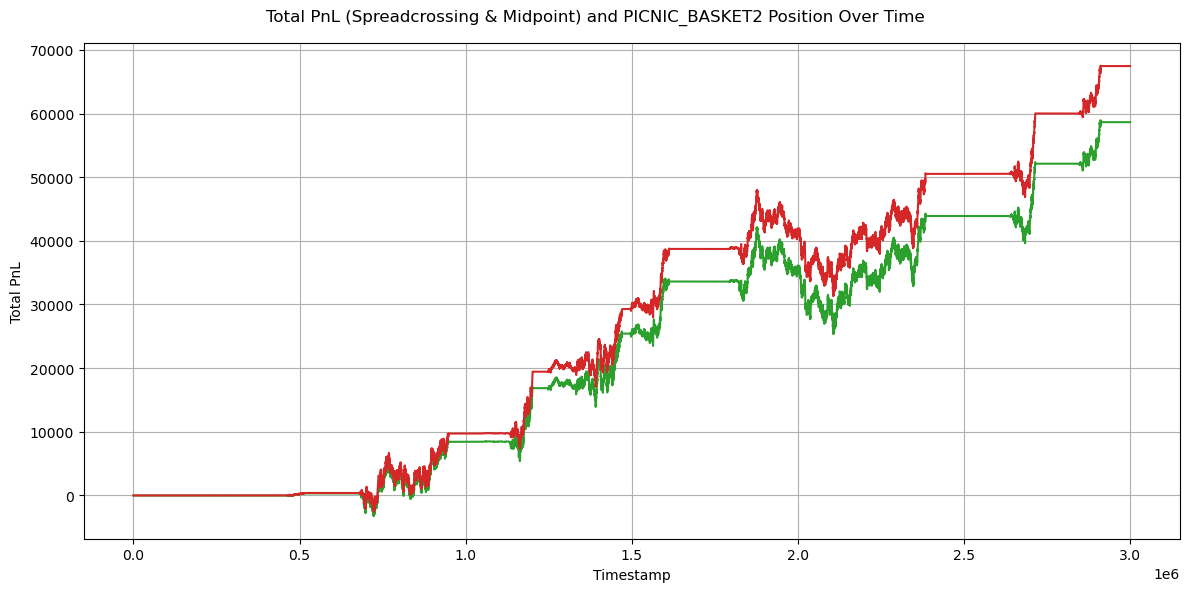

In [322]:
# 1. Calculate metrics for each symbol
metrics = {symbol: bt.calculate_metrics(symbol) for symbol in listings.keys()}

# 2. Compute total PnL over time for both strategies

# For Spreadcrossing PnL: Stack and sum over symbols
spread_pnl_matrix = np.array([metrics[sym]["spreadcrossing_pnl"] for sym in metrics])
total_spread_pnl_over_time = np.sum(spread_pnl_matrix, axis=0)

# For Midpoint PnL: Stack and sum over symbols
midpoint_pnl_matrix = np.array([metrics[sym]["midpoint_pnl"] for sym in metrics])
total_midpoint_pnl_over_time = np.sum(midpoint_pnl_matrix, axis=0)

# 3. Get the timestamps array (assuming all symbols share the same timestamps)
timestamps = metrics[next(iter(metrics))]["timestamp"]

# 4. Get position over time for a specific symbol (e.g., PICNIC_BASKET2)
etflog = Log.from_file('r3_b1vb2.log')
#picnic_timestamps, picnic_position = _calculate_position_over_time(PICNIC_BASKET2, etflog.trade_history, etflog.activities_log)

# 5. Plot total Spreadcrossing PnL and Midpoint PnL, and overlay PICNIC_BASKET2 position

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: Total PnL for both strategies
ax1.plot(timestamps, total_spread_pnl_over_time, color='tab:green', label="Total Spreadcrossing PnL")
ax1.plot(timestamps, total_midpoint_pnl_over_time, color='tab:red', label="Total Midpoint PnL")
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Total PnL", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Right y-axis: Position for PICNIC_BASKET2
#ax2 = ax1.twinx()
#ax2.plot(picnic_timestamps, picnic_position, color='tab:blue', linestyle='--', label="PICNIC_BASKET2 Position")
#ax2.set_ylabel("Position (PICNIC_BASKET2)", color='tab:blue')
#ax2.tick_params(axis='y', labelcolor='tab:blue')

# Combine legends from both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
#ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Title and adjust layout
fig.suptitle("Total PnL (Spreadcrossing & Midpoint) and PICNIC_BASKET2 Position Over Time")
fig.tight_layout()
plt.show()

In [323]:
edge_0 = 70
edge_max = 150

edge_max_retreet = 100
edge_0_retreet = 0

position_max = int(250/4)

In [314]:
pos_sell = exit_size_function(95, edge_0_retreet, edge_max_retreet, position_max)
pos_sell

-61.845

In [315]:
size_function(133, edge_0, edge_max, position_max)

-38.449687499999996